In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rc('figure', figsize=(16.0, 4.0))

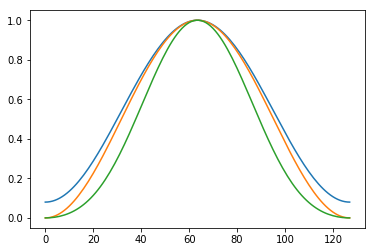

In [59]:
plt.plot(np.hamming(128))
plt.plot(np.hanning(128))
plt.plot(np.blackman(128))

In [2]:
import librosa
signal, samplerate = librosa.load("/home/mars/musictoys/boat.wav", sr=44100)
onset_env = librosa.onset.onset_strength(signal, sr=samplerate)                      
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=samplerate) 

In [3]:
def track_onset(envelope, framerate, bpm):
    # Given an estimated overall tempo, search the envelope for an arrangement
    # of onset peaks which produces the best fit for a beat grid. This is from
    # the paper "Beat Tracking with Dynamic Programming" by Daniel P. W. Ellis.
    # We will return an array of estimated beat times, in seconds.
    assert bpm > 0
    assert framerate > 0
    period = round(60.0 * framerate / bpm)

    # Make sure the onset envelope is sane: it should have enough length that
    # it is plausible we might find beats in it, and it should range 0..1.
    if len(envelope) < framerate:
        print "bogus empty envelope is only %d items long at %.2f" % (len(envelope), framerate)
        return np.zeros(0, dtype=np.float)
    onset_norm = envelope.std(ddof=1)
    if onset_norm > 0:
        print "normalizing envelope with factor %.3f" % onset_norm
        envelope = envelope / onset_norm

    # Reduce local fluctuations, smoothing the envelope with a Gaussian window
    # spanning 1/32 of the estimated beat interval.
    window = np.exp(-0.5 * (np.arange(-period, period+1)*32.0/period)**2)
    #window = np.exp(-0.5 * np.linspace(-32.0, 32.0, period*2+1) ** 2)
    local_scores = np.convolve(envelope, window, 'same')

    # Use a log-gaussian cost function for distance from expected bpm.
    tightness = 100
    window = np.arange(-2 * period, -np.round(period / 2) + 1, dtype=np.int)
    txwt = -tightness * (np.log(-window / period) ** 2)
    # Are we on the first beat?
    #!!! the Ellis paper starts with backlinks at -1, not 0?
    backlink = np.zeros_like(local_scores, dtype=np.int)
    total_scores = np.zeros_like(local_scores)
    first_beat = True
    for i, score in enumerate(local_scores):
        # Are we reaching back before time 0?
        z_pad = np.maximum(0, min(-window[0], len(window)))
        # Search over all possible predecessors
        candidates = txwt.copy()
        candidates[z_pad:] = candidates[z_pad:] + total_scores[window[z_pad:]]
        # Find the best preceding beat
        beat_location = np.argmax(candidates)
        # Add the local score
        total_scores[i] = score + candidates[beat_location]
        # Special case the first onset.  Stop if the local score is small
        if first_beat and score < 0.01 * local_scores.max():
            backlink[i] = -1
        else:
            backlink[i] = window[beat_location]
            first_beat = False
        # Update the time range
        window = window + 1

    # Get the position of the last beat. Measure the degree to which each
    # frame is a local maximum, then pick local maxima which exceed the global
    # median by a factor of 2, then select the last of these.
    score_pad = np.pad(total_scores, [(1,1)], mode='edge')
    maxes = (total_scores > score_pad[:-2]) & (total_scores >= score_pad[2:])
    med_score = np.median(total_scores[np.argwhere(maxes)])
    last_beat = np.argwhere((total_scores * maxes * 2 > med_score)).max()

    # Reconstruct the most probable beat path from the series of backlinks,
    # then create an array in ascending order.
    beats = [last_beat]
    while backlink[beats[-1]] >= 0:
        beats.append(backlink[beats[-1]])
    beats = np.array(beats[::-1], dtype=np.int)

    # Discard low-probability beats at the beginning and end.
    smooth_boe = np.convolve(local_scores[beats], np.hanning(5), 'same')
    threshold = 0.5 * ((smooth_boe ** 2).mean() ** 0.5)
    valid = np.argwhere(smooth_boe > threshold)
    beats = beats[valid.min():valid.max()]

    # Convert the beat frame indexes into timestamps.
    return np.asarray(beats, dtype=np.float) / framerate


normalizing envelope with factor 1.766
[   2.34521542    2.84444444    3.34367347    3.84290249    4.34213152
    4.84136054    5.34058957    5.83981859    6.33904762    6.82666667
    7.33750567    7.82512472    8.33596372    8.82358277    9.33442177
    9.82204082   10.33287982   10.82049887   11.33133787   11.81895692
   12.3414059    12.82902494   13.32825397   13.82748299   14.338322
   14.82594104   15.33678005   15.82439909   16.3352381    16.82285714
   17.33369615   17.82131519   18.3321542    18.83138322   19.33061224
   19.82984127   20.34068027   20.82829932   21.32752834   21.82675737
   22.34920635   22.84843537   23.3476644    23.8585034    24.35773243
   24.85696145   25.3445805    25.82058957   26.33142857   26.84226757
   27.3414966    27.84072562   28.33995465   28.83918367   29.3384127
   29.83764172   30.33687075   30.83609977   31.3353288    31.83455782
   32.33378685   32.83301587   33.3322449    33.8430839    34.34231293
   34.84154195   35.34077098   35.84     

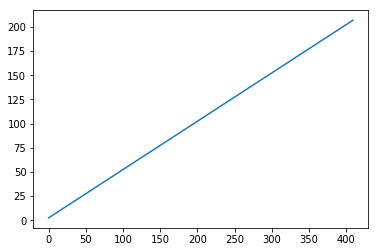

In [4]:
marsbeats = track_onset(onset_env, float(samplerate)/512.0, tempo)
plt.plot(marsbeats)
print marsbeats

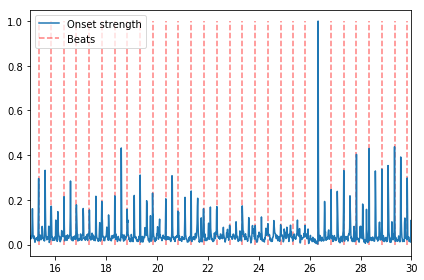

In [5]:
import librosa.display
times = np.linspace(0, float(len(signal)) / samplerate, len(onset_env))
plt.plot(times, librosa.util.normalize(onset_env), label='Onset strength')
plt.vlines(marsbeats, 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
plt.legend(frameon=True, framealpha=0.75)
# Limit the plot to a 15-second window
plt.xlim(15, 30)
plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()